<a href="https://colab.research.google.com/github/OleksiiLatypov/Loan_Approval_Prediction/blob/main/Fork_of_Loan_Approval_Prediction_CatBoost%2BOptuna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

playground_series_s4e10_path = kagglehub.competition_download('playground-series-s4e10')
oleksiilatypov_credit_risk_path = kagglehub.dataset_download('oleksiilatypov/credit-risk')

print('Data source import complete.')


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e10/sample_submission.csv
/kaggle/input/playground-series-s4e10/train.csv
/kaggle/input/playground-series-s4e10/test.csv
/kaggle/input/credit-risk/credit_risk_dataset.csv


In [ ]:
train = pd.read_csv('/kaggle/input/playground-series-s4e10/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s4e10/test.csv')
original = pd.read_csv('/kaggle/input/credit-risk/credit_risk_dataset.csv')

In [ ]:
print(train.shape)
print(test.shape)
print(original.shape)

(58645, 13)
(39098, 12)
(32581, 12)


In [ ]:
train.loan_status.value_counts()

loan_status
0    50295
1     8350
Name: count, dtype: int64

In [ ]:
original.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [ ]:
# concatenate train and original datasets and explore data

train_origin = pd.concat([train, original], axis=0, ignore_index=True)
train_origin.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0.0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1.0,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2.0,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3.0,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,4.0,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [ ]:
train_origin['loan_status'].value_counts()

loan_status
0    75768
1    15458
Name: count, dtype: int64

In [ ]:
imbalanced_ratio = train_origin['loan_status'].value_counts()[1] / train_origin['loan_status'].value_counts()[0]
imbalanced_ratio

0.20401752718825888

The imbalanced ratio of approximately 0.204 indicates that the dataset has a imbalance between the two classes of loan status. The model may face some challenges in accurately predicting the minority class.

In [ ]:
# drop id column, it is uneccessery column
train_origin = train_origin.drop('id', axis=1)

In [ ]:
train_origin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91226 entries, 0 to 91225
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  91226 non-null  int64  
 1   person_income               91226 non-null  int64  
 2   person_home_ownership       91226 non-null  object 
 3   person_emp_length           90331 non-null  float64
 4   loan_intent                 91226 non-null  object 
 5   loan_grade                  91226 non-null  object 
 6   loan_amnt                   91226 non-null  int64  
 7   loan_int_rate               88110 non-null  float64
 8   loan_percent_income         91226 non-null  float64
 9   cb_person_default_on_file   91226 non-null  object 
 10  cb_person_cred_hist_length  91226 non-null  int64  
 11  loan_status                 91226 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 8.4+ MB


In [ ]:
train_origin.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status
count,91226.000000,9.122600e+04,90331.000000,91226.000000,88110.000000,91226.000000,91226.000000,91226.000000
mean,27.616480,6.477071e+04,4.732119,9350.348607,10.789508,0.163154,5.810219,0.169447
std,6.148115,4.793696e+04,4.025068,5848.605423,3.108998,0.097491,4.038412,0.375149
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,0.000000
25%,23.000000,4.000000e+04,2.000000,5000.000000,7.880000,0.090000,3.000000,0.000000
50%,26.000000,5.700000e+04,4.000000,8000.000000,10.950000,0.140000,4.000000,0.000000
75%,30.000000,7.800000e+04,7.000000,12000.000000,13.110000,0.220000,8.000000,0.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,0.830000,30.000000,1.000000


In [ ]:
test.describe()

,id,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length
count,39098.000000,39098.000000,3.909800e+04,39098.000000,39098.000000,39098.000000,39098.000000,39098.000000
mean,78193.500000,27.566781,6.406046e+04,4.687068,9251.466188,10.661216,0.159573,5.830707
std,11286.764749,6.032761,3.795583e+04,3.868395,5576.254680,3.020220,0.091633,4.072157
min,58645.000000,20.000000,4.000000e+03,0.000000,700.000000,5.420000,0.000000,2.000000
25%,68419.250000,23.000000,4.200000e+04,2.000000,5000.000000,7.880000,0.090000,3.000000
50%,78193.500000,26.000000,5.800000e+04,4.000000,8000.000000,10.750000,0.140000,4.000000
75%,87967.750000,30.000000,7.588500e+04,7.000000,12000.000000,12.990000,0.210000,8.000000
max,97742.000000,94.000000,1.900000e+06,42.000000,35000.000000,22.110000,0.730000,30.000000


Some applicants as old as 144, indicating potential outliers or data inaccuracies. The same with employment length.

In [ ]:
train_origin.describe(include='object')

,person_home_ownership,loan_intent,loan_grade,cb_person_default_on_file
count,91226,91226,91226,91226
unique,4,6,7,2
top,RENT,EDUCATION,A,N
freq,47040,18724,31761,76779


In [ ]:
train_origin.duplicated().sum()

165

In [ ]:
# Display the duplicated rows
train_origin[train_origin.duplicated(keep=False)]
dup = train_origin[train_origin.index == 58659]

duplic = train_origin[train_origin.duplicated(keep=False)]
duplic[(duplic['person_age'] == 23) &
       (duplic['person_income'] == 115000) &
       (duplic['person_home_ownership'] == 'RENT')]


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
58659,23,115000,RENT,2.0,EDUCATION,A,35000,7.9,0.3,N,4,0
75611,23,115000,RENT,2.0,EDUCATION,A,35000,7.9,0.3,N,4,0


In [ ]:
train_origin.drop_duplicates(inplace=True)

In [ ]:
train_origin.duplicated().sum()

0

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

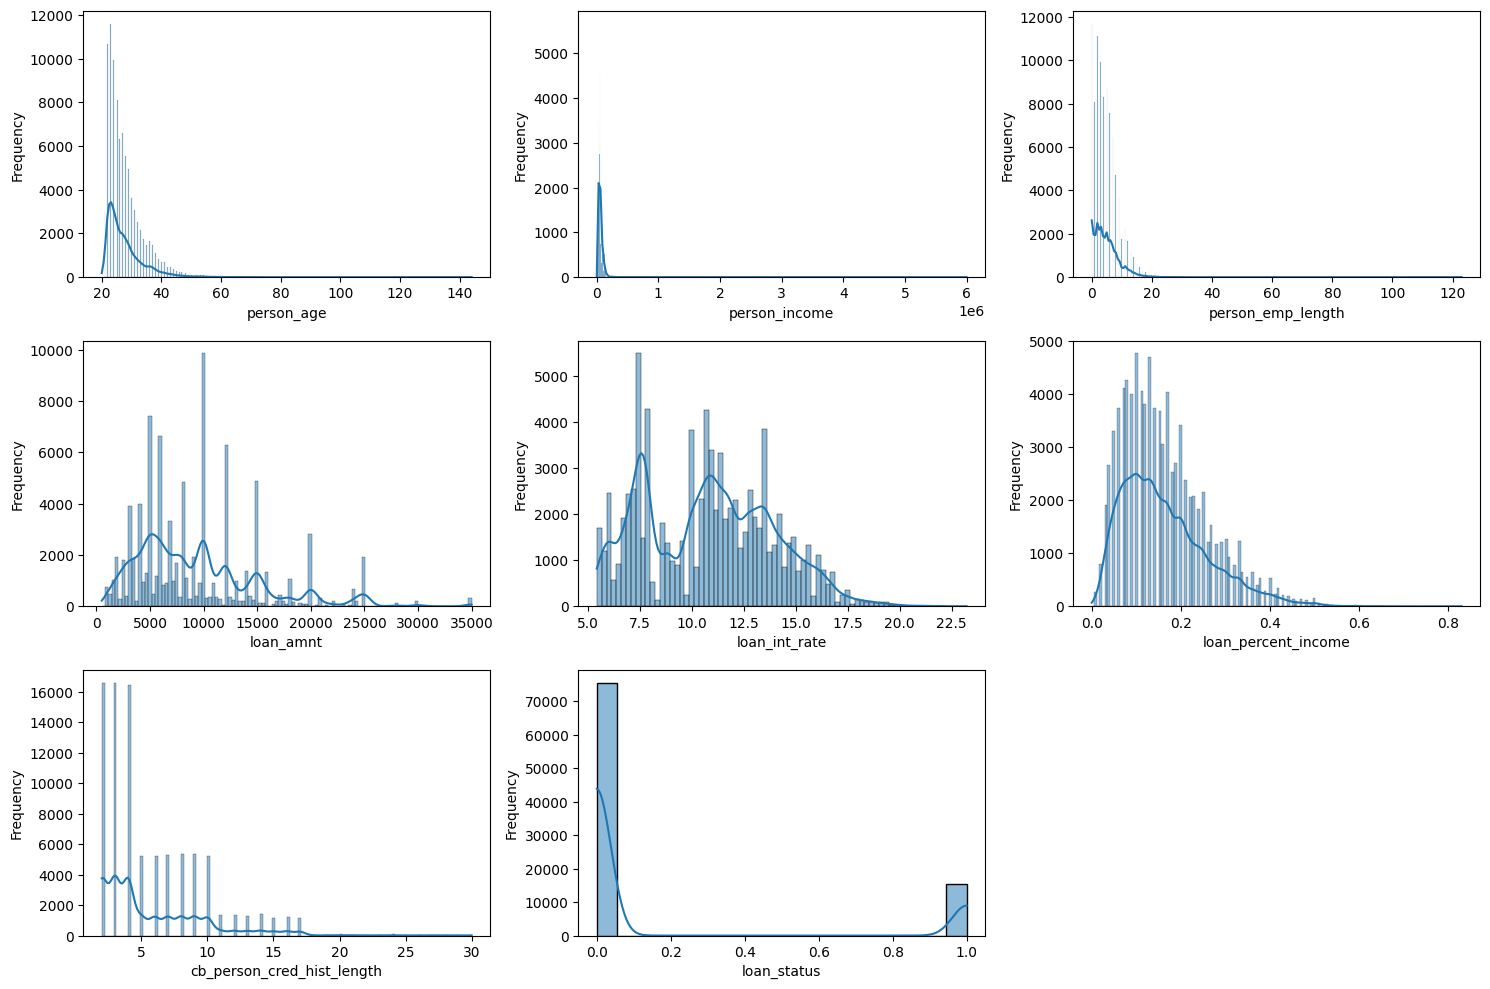

In [ ]:
numerical_features = train_origin.select_dtypes(include=['number'])

plt.figure(figsize=(15, 10))

for i, feature in enumerate(numerical_features, 1):
    plt.subplot(3, 3, i)
    sns.histplot(train_origin[feature], kde=True)
    plt.xlabel(feature)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [ ]:
numerical_features.corrwith(numerical_features.loan_status).abs().sort_values(ascending=False)[1:]

loan_percent_income           0.381796
loan_int_rate                 0.340284
person_income                 0.152274
loan_amnt                     0.130557
person_emp_length             0.091844
person_age                    0.008374
cb_person_cred_hist_length    0.008339
dtype: float64

<Axes: >

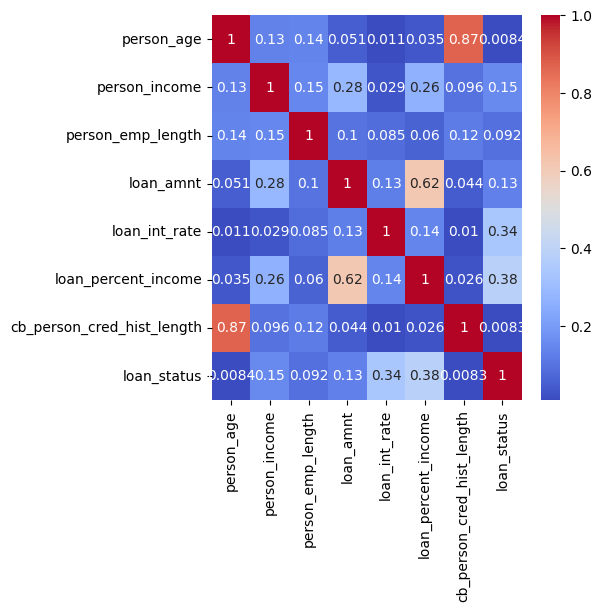

In [ ]:
plt.figure(figsize=(5, 5))
corr_data = numerical_features.corr().abs()
sns.heatmap(corr_data, annot=True, cmap='coolwarm')

**High correlation between person_age and cb_person_cred_hist_length:**
There is a strong positive correlation (0.87) between person_age and cb_person_cred_hist_length. This makes sense as the length of a person’s credit history is likely to increase with age.

**Moderate correlations involving loan_percent_income:**
loan_percent_income has a moderate positive correlation (0.62) with loan_amnt, indicating that higher loan amounts often represent a higher percentage of a person's income.

In [ ]:
categorical_features = train_origin.select_dtypes(include=['object'])
res = {}
for column in categorical_features.columns:
    res[column] = categorical_features[column].unique()
res

{'person_home_ownership': array(['RENT', 'OWN', 'MORTGAGE', 'OTHER'], dtype=object),
 'loan_intent': array(['EDUCATION', 'MEDICAL', 'PERSONAL', 'VENTURE', 'DEBTCONSOLIDATION',
        'HOMEIMPROVEMENT'], dtype=object),
 'loan_grade': array(['B', 'C', 'A', 'D', 'E', 'F', 'G'], dtype=object),
 'cb_person_default_on_file': array(['N', 'Y'], dtype=object)}

In [ ]:
loan_grade_group = train_origin.groupby(['loan_grade'])['loan_status'].agg(['count', 'mean'])
loan_grade_group

,count,mean
loan_grade,,
A,31687,0.066210
B,30787,0.122844
C,17474,0.161955
D,8654,0.592327
E,1972,0.634888
F,390,0.669231
G,97,0.927835


97 persons  with grade 'G' has 92% of loan_staus (1)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='loan_grade', ylabel='Count'>

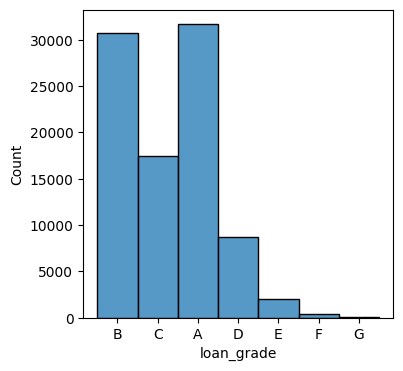

In [ ]:
plt.figure(figsize=(4, 4))
sns.histplot(train_origin['loan_grade'])

In [ ]:
loan_intent_group = train_origin.groupby(['loan_intent'])['loan_status'].agg(['count', 'mean'])
loan_intent_group

,count,mean
loan_intent,,
DEBTCONSOLIDATION,14322,0.224619
EDUCATION,18682,0.129965
HOMEIMPROVEMENT,9874,0.205692
MEDICAL,16976,0.210061
PERSONAL,15514,0.156246
VENTURE,15693,0.112980


In [ ]:
person_home_ownership_group = train_origin.groupby(['person_home_ownership'])['loan_status'].agg(['count', 'mean'])
person_home_ownership_group

,count,mean
person_home_ownership,,
MORTGAGE,38193,0.083000
OTHER,195,0.246154
OWN,5701,0.041221
RENT,46972,0.255173


The majority of borrowers fall into the "RENT" category (47,040), followed by "MORTGAGE" (38,268), "OWN" (5,722), and a small number in "OTHER" (196). This distribution suggests that a large segment of the loan applicants are renting their homes.

In [ ]:
cb_person_default_on_file_group = train_origin.groupby(['cb_person_default_on_file'])['loan_status'].agg(['count', 'mean'])
cb_person_default_on_file_group

,count,mean
cb_person_default_on_file,,
N,76629,0.139216
Y,14432,0.330585


The majority of borrowers in the dataset do not have a default on file, with 76,779 individuals in the "N" (No) category, compared to 14,447 in the "Y" (Yes) category. This suggests that a significant portion of the applicants have a clean credit history.

In [ ]:
# all persons older then 80 have loan_status (0)
train_origin[train_origin['person_age'] > 80]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
4962,84,108928,MORTGAGE,3.0,DEBTCONSOLIDATION,A,6000,7.51,0.06,N,25,0
6750,84,94800,MORTGAGE,2.0,PERSONAL,D,10000,14.09,0.11,N,22,0
47336,123,36000,MORTGAGE,7.0,PERSONAL,B,6700,10.75,0.18,N,4,0
58726,144,250000,RENT,4.0,VENTURE,C,4800,13.57,0.02,N,3,0
58828,144,200000,MORTGAGE,4.0,EDUCATION,B,6000,11.86,0.03,N,2,0
59220,123,80004,RENT,2.0,EDUCATION,B,20400,10.25,0.25,N,3,0
59392,123,78000,RENT,7.0,VENTURE,B,20000,NaN,0.26,N,4,0
90942,144,6000000,MORTGAGE,12.0,PERSONAL,C,5000,12.73,0.00,N,25,0
91061,94,24000,RENT,1.0,MEDICAL,C,6500,NaN,0.27,N,27,0
91151,84,94800,MORTGAGE,2.0,PERSONAL,A,10000,7.51,0.11,N,24,0


In [ ]:
# drop persons with age more then 80
train_origin = train_origin.drop(train_origin[train_origin['person_age'] > 80].index)

In [ ]:
train_origin[(train_origin['person_emp_length'] > 30) & (train_origin['person_age'] < 50)]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
24214,43,50000,RENT,35.0,DEBTCONSOLIDATION,A,9000,5.42,0.18,N,16,0
26125,43,56000,RENT,41.0,HOMEIMPROVEMENT,B,2000,10.99,0.04,N,14,0
29271,47,53913,MORTGAGE,31.0,HOMEIMPROVEMENT,B,7000,10.71,0.13,N,13,1
39112,46,84000,MORTGAGE,31.0,HOMEIMPROVEMENT,D,20000,17.49,0.24,N,8,0
41079,28,60350,MORTGAGE,123.0,MEDICAL,D,25000,15.95,0.35,Y,6,1
48287,48,70000,MORTGAGE,31.0,HOMEIMPROVEMENT,A,9000,8.94,0.13,N,8,0
49252,21,192000,MORTGAGE,123.0,VENTURE,B,20000,11.49,0.10,N,2,0
52038,38,42000,MORTGAGE,31.0,VENTURE,B,11000,11.49,0.26,N,14,0
53832,46,52000,MORTGAGE,31.0,VENTURE,B,10000,9.91,0.19,N,16,0
58645,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,0.59,Y,3,1


The employment length of 123 years for individuals aged 21 to 28 is clearly unrealistic, suggesting data entry errors or anomalies and some clients have difference between age and length of the employment less then 18 year

In [ ]:
train_origin[(train_origin['person_age'] - train_origin['person_emp_length']) < 0]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
41079,28,60350,MORTGAGE,123.0,MEDICAL,D,25000,15.95,0.35,Y,6,1
49252,21,192000,MORTGAGE,123.0,VENTURE,B,20000,11.49,0.10,N,2,0
58645,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,0.59,Y,3,1
58855,21,192000,MORTGAGE,123.0,VENTURE,A,20000,6.54,0.10,N,4,0


In [ ]:
indices_to_drop = train_origin.index[(train_origin['person_age'] - train_origin['person_emp_length']) < 0]
train_origin = train_origin.drop(indices_to_drop)

In [ ]:
train_origin[train_origin['person_emp_length'] == 123]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status


In [ ]:
# treshhold to separate train_df and test_df
limit = train_origin.shape[0]
limit

91047

In [ ]:
test = test.drop('id', axis=1)

In [ ]:
df = pd.concat([train_origin, test], axis=0, ignore_index=True)

In [ ]:
df.shape

(130145, 12)

In [ ]:
100 * (train_origin.isna().sum()/len(test)).sort_values(ascending=False)

loan_int_rate                 7.910891
person_emp_length             2.268658
person_age                    0.000000
person_income                 0.000000
person_home_ownership         0.000000
loan_intent                   0.000000
loan_grade                    0.000000
loan_amnt                     0.000000
loan_percent_income           0.000000
cb_person_default_on_file     0.000000
cb_person_cred_hist_length    0.000000
loan_status                   0.000000
dtype: float64

**Fill missing values, with median**

In [ ]:
df['person_emp_length']  = df['person_emp_length'].fillna(df['person_emp_length'].median())
df['loan_int_rate']  = df['loan_int_rate'].fillna(df['loan_int_rate'].median())
# Step 1: Create the binary column marking only NaN values
# df['person_emp_length_missing'] = df['person_emp_length'].isna().astype(int)

# # Step 2: Fill missing values with 0 in the original column
# df['person_emp_length'] = df['person_emp_length'].fillna(-1)

# df['loan_int_rate_missing'] = df['loan_int_rate'].isna().astype(int)
# df['loan_int_rate'] = df['loan_int_rate'].fillna(-1)



In [ ]:
df.isna().sum()

person_age                        0
person_income                     0
person_home_ownership             0
person_emp_length                 0
loan_intent                       0
loan_grade                        0
loan_amnt                         0
loan_int_rate                     0
loan_percent_income               0
cb_person_default_on_file         0
cb_person_cred_hist_length        0
loan_status                   39098
dtype: int64

**Create new additional feature**

In [ ]:
#df[(df['loan_int_rate'] == -1)]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status,person_emp_length_missing,loan_int_rate_missing
58678,23,71500,RENT,3.0,DEBTCONSOLIDATION,D,30000,-1.0,0.42,N,4,1.0,0,1
58689,24,78000,RENT,4.0,DEBTCONSOLIDATION,D,30000,-1.0,0.38,Y,4,1.0,0,1
58696,23,277000,OWN,3.0,PERSONAL,A,35000,-1.0,0.13,N,4,0.0,0,1
58698,24,12000,OWN,2.0,VENTURE,E,1750,-1.0,0.15,Y,3,0.0,0,1
58701,26,263000,MORTGAGE,0.0,EDUCATION,B,10000,-1.0,0.04,N,4,1.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91178,53,4888,OWN,0.0,VENTURE,C,1400,-1.0,0.29,Y,28,1.0,0,1
91183,65,45900,RENT,2.0,EDUCATION,C,10000,-1.0,0.22,Y,19,0.0,0,1
91184,54,20000,RENT,2.0,MEDICAL,C,5000,-1.0,0.25,N,28,0.0,0,1
91200,51,60000,MORTGAGE,1.0,PERSONAL,A,7500,-1.0,0.13,N,23,0.0,0,1


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='person_income', ylabel='Count'>

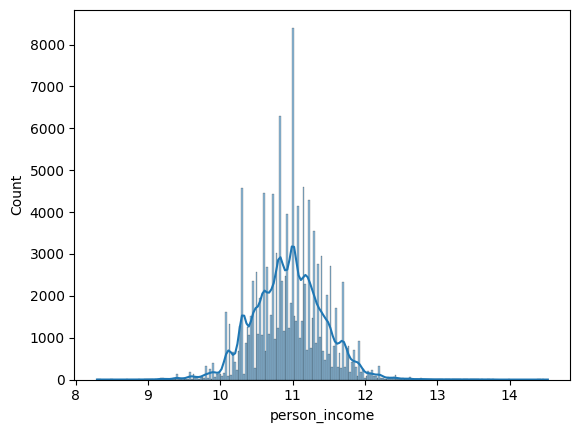

In [ ]:
sns.histplot(np.log(df['person_income']), kde=True)

In [ ]:
#Debt-to-Income Ratio
df['dti'] = df['loan_amnt'] / df['person_income']

# #Employment Stability
# df['emp_stability'] = df['person_emp_length'].apply(lambda x: 1 if x > 5 else 0)

#df['person_income'] = np.log(df['person_income'])

# df['person_inc_age'] = df['person_income'] * df['person_age']


# df['loan_amnt_int_rate'] = df['loan_amnt'] * df['loan_int_rate']

#Home Ownership Binary Feature
# def cred_hist_category(cred_hist_length):
#     if cred_hist_length < 5:
#         return 'short_history'
#     elif 5 <= cred_hist_length <= 10:
#         return 'medium_history'
#     else:
#         return 'long_history'

# df['cred_hist_category'] = df['cb_person_cred_hist_length'].apply(cred_hist_category)


In [ ]:
df.head(3)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status,dti
0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0.0,0.171429
1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0.0,0.071429
2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0.0,0.208333


In [ ]:
#df_encoded = pd.get_dummies(df, drop_first=True, dtype='int')
loan_grade_dict = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6}
cb_person_default_on_file_dict = {'N': 0, 'Y':1}
#cred_hist_category_dict = {'long_history': 0, 'medium_history': 1, 'short_history': 2}
person_home_ownership_dict = {'RENT': 0, 'MORTGAGE': 1, 'OWN': 2, 'OTHER': 3}
loan_intent_dict = {'EDUCATION': 0, 'MEDICAL': 1, 'PERSONAL': 2, 'VENTURE': 3, 'DEBTCONSOLIDATION': 4, 'HOMEIMPROVEMENT': 5}

df['loan_grade'] = df['loan_grade'].map(loan_grade_dict)
df['cb_person_default_on_file'] = df['cb_person_default_on_file'].map(cb_person_default_on_file_dict)
df['person_home_ownership'] = df['person_home_ownership'].map(person_home_ownership_dict)
df['loan_intent'] = df['loan_intent'].map(loan_intent_dict)
#df['cred_hist_category'] = df['cred_hist_category'].map(cred_hist_category_dict)

In [ ]:
df.head(3)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status,dti
0,37,35000,0,0.0,0,1,6000,11.49,0.17,0,14,0.0,0.171429
1,22,56000,2,6.0,1,2,4000,13.35,0.07,0,2,0.0,0.071429
2,29,28800,2,8.0,2,0,6000,8.90,0.21,0,10,0.0,0.208333


In [ ]:
train_df = df.iloc[:limit, :]
test_df = df.iloc[limit:, :]

In [ ]:
train_df.isna().sum()

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
loan_status                   0
dti                           0
dtype: int64

In [ ]:
y = train_df['loan_status']
X = train_df.drop('loan_status', axis=1)

**RandomForestClassifier**

In [ ]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score


# Define StratifiedKFold
skf = StratifiedKFold(n_splits=5)  # 5-fold cross-validation

# Model to train
model_rf = RandomForestClassifier(class_weight='balanced', random_state=42)


# List to store AUC scores
auc_scores = []

# Cross-validation process
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Train the model
    model_rf.fit(X_train, y_train)

    # Get predicted probabilities for the positive class
    y_prob = model_rf.predict_proba(X_test)[:, 1]

    # Calculate AUC
    auc = roc_auc_score(y_test, y_prob)
    print(auc)
    auc_scores.append(auc)

# Average AUC across all folds
print(f"Average AUC: {sum(auc_scores) / len(auc_scores):.4f}")


In [ ]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

# Assuming X and y are defined, where X is your feature set and y is the target variable.

# Define StratifiedKFold
skf = StratifiedKFold(n_splits=5)   # 5-fold cross-validation

# Model to train
model_logistic = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)

# List to store AUC scores
auc_scores = []

# Cross-validation process
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Normalize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train the model
    model_logistic.fit(X_train_scaled, y_train)

    # Get predicted probabilities for the positive class
    y_prob = model_logistic.predict_proba(X_test_scaled)[:, 1]

    # Calculate AUC
    auc = roc_auc_score(y_test, y_prob)
    print(f"AUC: {auc:.4f}")
    auc_scores.append(auc)

# Average AUC across all folds
average_auc = sum(auc_scores) / len(auc_scores)
print(f"Average AUC: {average_auc:.4f}")


**XGBoostClassifier**

In [ ]:
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score


# Define StratifiedKFold
skf = StratifiedKFold(n_splits=5)  # 5-fold cross-validation

# Model to train
model_xgb = xgb.XGBClassifier(
    scale_pos_weight=4,  # Adjust this based on imbalance ratio
    use_label_encoder=False,  # Avoids label encoding warning
    eval_metric='auc',  # Use AUC as the evaluation metric
    random_state=42
)


# List to store AUC scores
auc_scores = []

# Cross-validation process
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Train the model
    model_xgb.fit(X_train, y_train)

    # Get predicted probabilities for the positive class
    y_prob = model_xgb.predict_proba(X_test)[:, 1]

    # Calculate AUC
    auc = roc_auc_score(y_test, y_prob)
    print(auc)
    auc_scores.append(auc)

# Average AUC across all folds
print(f"Average AUC: {sum(auc_scores) / len(auc_scores):.4f}")


**CatBoostClassifier**

In [ ]:
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score


# Define StratifiedKFold
skf = StratifiedKFold(n_splits=5)   # 5-fold cross-validation

# Model to train
model_cat = CatBoostClassifier(
    iterations=1000,             # Number of boosting iterations
    learning_rate=0.1,           # Learning rate
    depth=4,                     # Depth of the trees
    class_weights=[1, 4],        # Adjust class weights (example: 1 for majority, 4 for minority)
    eval_metric='AUC',           # Use AUC as the evaluation metric
    random_seed=42,
    verbose=100                  # Print progress every 100 iterations
)

# List to store AUC scores
auc_scores = []

# Cross-validation process
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Train the model
    model_cat.fit(X_train, y_train, verbose=False)

    # Get predicted probabilities for the positive class
    y_prob = model_cat.predict_proba(X_test)[:, 1]

    # Calculate AUC
    auc = roc_auc_score(y_test, y_prob)
    print(auc)
    auc_scores.append(auc)

# Average AUC across all folds
print(f"Average AUC: {sum(auc_scores) / len(auc_scores):.4f}")


0.9609632887403522
0.9621904837203183
0.9649865897952886
0.9450635961301594
0.9445270465584159
Average AUC: 0.9555


**LGBMClassifier**

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score


# Define StratifiedKFold
skf = StratifiedKFold(n_splits=5)   # 5-fold cross-validation

# Model to train
model_lgb_38 = lgb.LGBMClassifier(
    n_estimators=1000,            # Number of boosting iterations
    learning_rate=0.1,            # Learning rate
    max_depth=4,                  # Depth of the trees
    class_weight='balanced',      # Automatically adjust weights for class imbalance
    random_state=42,
    verbose=-1
)

# List to store AUC scores
auc_scores = []

# Cross-validation process
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Train the model
    model_lgb_38.fit(X_train, y_train)

    # Get predicted probabilities for the positive class
    y_prob = model_lgb_38.predict_proba(X_test)[:, 1]

    # Calculate AUC
    auc = roc_auc_score(y_test, y_prob)
    print(auc)
    auc_scores.append(auc)

# Average AUC across all folds
print(f"Average AUC: {sum(auc_scores) / len(auc_scores):.4f}")
#0.9603

0.9604459071077697
0.9626486201550268
0.9650976130274455
0.9470482690695984
0.9431856008094441
Average AUC: 0.9557


In [ ]:
results_df.sort_values(by='std_auc').head(50)

In [ ]:
catboost_results_df.sort_values(by='std_auc')

In [ ]:
# Define StratifiedKFold
skf = StratifiedKFold(n_splits=5)   # 5-fold cross-validation



model_cat = CatBoostClassifier(
    iterations=1497,
    learning_rate=0.19862700515892123,
    depth=3,
    class_weights={0: 1, 1: 2.8609507839857535},  # Example of giving more weight to the minority class
#    cat_features=cat_features,
    border_count = 241,
    eval_metric='AUC',           # Use AUC as the evaluation metric
    random_seed=42,
    verbose=100
)

# List to store AUC scores
auc_scores = []

# Cross-validation process
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Train the model
    model_cat.fit(X_train, y_train)

    # Get predicted probabilities for the positive class
    y_prob = model_cat.predict_proba(X_test)[:, 1]

    # Calculate AUC
    auc = roc_auc_score(y_test, y_prob)
    print(auc)
    auc_scores.append(auc)

# Average AUC across all folds
print(f"Average AUC: {sum(auc_scores) / len(auc_scores):.4f}")


0:	total: 9.57ms	remaining: 14.3s
100:	total: 981ms	remaining: 13.6s
200:	total: 1.94s	remaining: 12.5s
300:	total: 2.88s	remaining: 11.4s
400:	total: 3.84s	remaining: 10.5s
500:	total: 4.86s	remaining: 9.67s
600:	total: 6.08s	remaining: 9.07s
700:	total: 7.21s	remaining: 8.19s
800:	total: 8.16s	remaining: 7.09s
900:	total: 9.12s	remaining: 6.03s
1000:	total: 10.1s	remaining: 4.99s
1100:	total: 11s	remaining: 3.96s
1200:	total: 12s	remaining: 2.95s
1300:	total: 12.9s	remaining: 1.95s
1400:	total: 13.9s	remaining: 952ms
1496:	total: 14.9s	remaining: 0us
0.9614813335133315
0:	total: 9.35ms	remaining: 14s
100:	total: 971ms	remaining: 13.4s
200:	total: 1.92s	remaining: 12.4s
300:	total: 2.87s	remaining: 11.4s
400:	total: 3.81s	remaining: 10.4s
500:	total: 4.75s	remaining: 9.44s
600:	total: 5.69s	remaining: 8.48s
700:	total: 6.65s	remaining: 7.55s
800:	total: 7.94s	remaining: 6.9s
900:	total: 9.21s	remaining: 6.09s
1000:	total: 10.2s	remaining: 5.03s
1100:	total: 11.1s	remaining: 4s
1200:	t

                       Feature  Importance
1                person_income   23.219830
11                         dti   18.926680
5                   loan_grade   16.275656
2        person_home_ownership   10.603062
4                  loan_intent   10.343677
8          loan_percent_income    7.209575
7                loan_int_rate    4.051539
3            person_emp_length    3.618705
0                   person_age    2.833420
6                    loan_amnt    2.190810
10  cb_person_cred_hist_length    0.652676
9    cb_person_default_on_file    0.074371


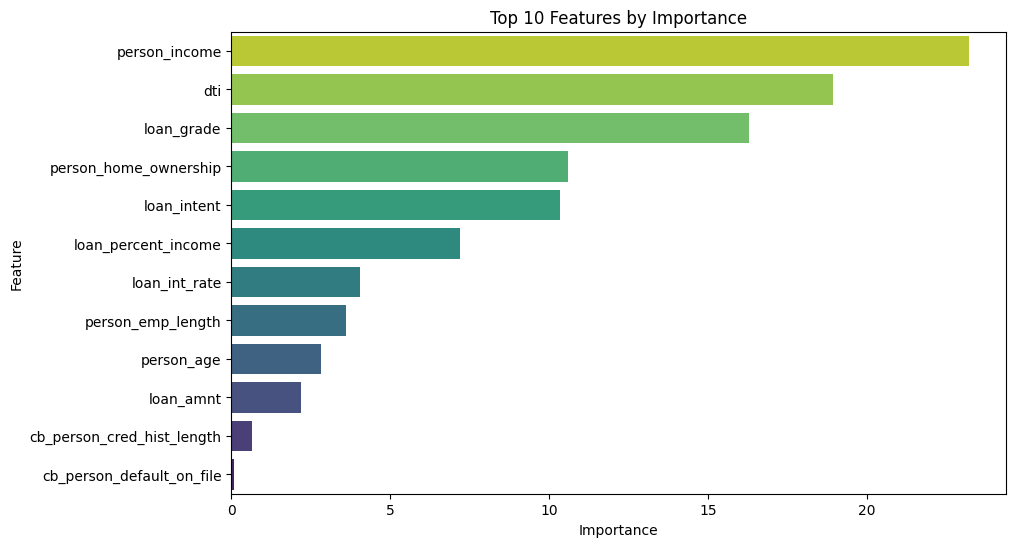

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importance
feature_importance = model_cat.get_feature_importance()

# Create a DataFrame to display feature importance
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importance
})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Print feature importance
print(importance_df)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.sort_values(by='Importance', ascending=True), palette='viridis')
plt.xlabel('Importance')
plt.title('Top 10 Features by Importance')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()


Optuna to find best hyperparametrs of model

In [ ]:
# import pandas as pd
# import optuna
# from sklearn.ensemble import GradientBoostingClassifier
# from sklearn.model_selection import StratifiedKFold
# from sklearn.metrics import roc_auc_score

# # Assuming X and y are your features and target variable
# # Define StratifiedKFold
# skf = StratifiedKFold(n_splits=5)

# # Define the objective function for Optuna
# def objective(trial):
#     # Suggest hyperparameters
#     n_estimators = trial.suggest_int('n_estimators', 50, 1000)  # Number of boosting iterations
#     learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)  # Learning rate
#     max_depth = trial.suggest_int('max_depth', 3, 6)  # Depth of the trees
#     min_samples_split = trial.suggest_int('min_samples_split', 2, 20)  # Minimum samples to split a node
#     min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)  # Minimum samples in leaf node

#     # Model to train
#     model_grb = GradientBoostingClassifier(
#         n_estimators=n_estimators,
#         learning_rate=learning_rate,
#         max_depth=max_depth,
#         min_samples_split=min_samples_split,
#         min_samples_leaf=min_samples_leaf,
#         random_state=42
#     )

#     # List to store AUC scores
#     auc_scores = []

#     # Cross-validation process
#     for train_index, test_index in skf.split(X, y):
#         X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#         y_train, y_test = y.iloc[train_index], y.iloc[test_index]

#         # Train the model
#         model_grb.fit(X_train, y_train)

#         # Get predicted probabilities for the positive class
#         y_prob = model_grb.predict_proba(X_test)[:, 1]

#         # Calculate AUC
#         auc = roc_auc_score(y_test, y_prob)
#         auc_scores.append(auc)

#     # Return the average AUC score across all folds
#     return sum(auc_scores) / len(auc_scores)

# # Create an Optuna study
# study = optuna.create_study(direction='maximize')  # We want to maximize AUC

# # Optimize the hyperparameters
# study.optimize(objective, n_trials=100)  # Number of trials to perform

# # Print the best hyperparameters and AUC score
# print("Best hyperparameters: ", study.best_params)
# print("Best AUC score: ", study.best_value)


In [ ]:
test_df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status,dti
91047,23,69000,0,3.0,5,5,25000,15.76,0.36,0,2,NaN,0.362319
91048,26,96000,1,6.0,2,2,10000,12.68,0.10,1,4,NaN,0.104167
91049,26,30000,0,5.0,3,4,4000,17.19,0.13,1,2,NaN,0.133333
91050,33,50000,0,4.0,4,0,7000,8.90,0.14,0,7,NaN,0.140000
91051,26,102000,1,8.0,5,3,15000,16.32,0.15,1,4,NaN,0.147059


In [ ]:
test_df = test_df.drop('loan_status', axis=1)

In [ ]:
test_predictions = model_lgb_38.predict_proba(test_df)[:, 1]

In [ ]:
test_predictions

array([0.99991785, 0.06261832, 0.86081875, ..., 0.02105396, 0.52828472,
       0.98867138])

In [ ]:
submission = pd.read_csv('/kaggle/input/playground-series-s4e10/sample_submission.csv')
submission['loan_status'] = test_predictions
submission.to_csv('submission_1710.csv', index=False)
submission.head()

,id,loan_status
0,58645,0.999918
1,58646,0.062618
2,58647,0.860819
3,58648,0.024691
4,58649,0.274417
